# Elife Binary Random Forest Results

Andrew E. Davidson  
aedaivds@ucsc.edu 04/11/24  

Copyright (c) 2020-2023, Regents of the University of California All rights reserved. https://polyformproject.org/licenses/noncommercial/1.0.0

feature importance plots based on  Gini Impurity. Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Impurity increases with randomness. We want features with less impurity.

**summary results for best hyperparmeter search results**   
elife samples are plasma extracelluar RNA gene expressions

For each of the 5 elife cancer types several biomarker sets where tried. The best of each set are plotted bellow

**<span style="color:red;background-color:yellow">4/16/24 fix a couple of gencode 37 to gencode 39 mapping bugs the stats are slightly better than those shown using unix head and cut</span>**  
```
$ pwd
/private/groups/kimlab/aedavids/elife/hyperparmeterTunning

$ ls *{COAD,Colon,READ}*/*log | tee colorectal.logs.txt
$ ls *{COAD,Colon,READ}*/*csv | tee colorectal.csvs.txt

$ls *csvs.txt
colorectal.csvs.txt  esophagus.csvs.txt  liver.csvs.txt  lung.csvs.txt  stomach.csvs.txt

$ head -n 2 `cat esophagus.csvs.txt ` | cut -d , -f 3,5,7
==> randomForestHyperparmeterEsophagus_ESCASearch.sh.out/randomForestHyperparmeterSearch.csv <==
sensitivity_mean,specificity_mean,auc_mean
0.7861111111111111,0.4238095238095238,0.6049603174603175

==> randomForestHyperparmeterEsophagus_Gastroesophageal_JunctionSearch.sh.out/randomForestHyperparmeterSearch.csv <==
sensitivity_mean,specificity_mean,auc_mean
0.9777777777777779,0.06666666666666667,0.5222222222222221

==> randomForestHyperparmeterEsophagus_MucosaSearch.sh.out/randomForestHyperparmeterSearch.allFloats.csv <==
sensitivity_mean,specificity_mean,auc_mean
0.7861111111111111,0.5142857142857143,0.6501984126984126

==> randomForestHyperparmeterEsophagus_MucosaSearch.sh.out/randomForestHyperparmeterSearch.csv <==
sensitivity_mean,specificity_mean,auc_mean
0.7888888888888889,0.5476190476190477,0.6682539682539683

==> randomForestHyperparmeterEsophagus_MucosaSearch.sh.out/randomForestHyperparmeterSearch.noAUC.csv <==
sensitivity_mean,specificity_mean,max_features
1.0,0.0,1.0

==> randomForestHyperparmeterEsophagus_MuscularisSearch.sh.out/randomForestHyperparmeterSearch.csv <==
sensitivity_mean,specificity_mean,auc_mean
0.6277777777777777,0.5714285714285715,0.5996031746031746

```

In [1]:
import ipynbname

# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display

import joblib
import math
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_rows', None)
import pprint as pp
import matplotlib.pyplot as plt

import scikitplot as skplt

from sklearn.ensemble        import RandomForestClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

import sys

notebookName = ipynbname.name()
notebookPath = ipynbname.path()
notebookDir = os.path.dirname(notebookPath)

#outDir = f'{notebookDir}/{notebookName}.out'
outDir = f'/private/groups/kimlab/aedavids/elife/{notebookName}.out'
os.makedirs(outDir, exist_ok=True)
print(f'outDir:\n{outDir}')

modelOutDir = os.path.join(outDir, "model")
os.makedirs(modelOutDir, exist_ok=True)
print(f'\nmodelOutDir ;\n{modelOutDir}')

# results of hyperparmeter search
hyperparameterOut = "/private/groups/kimlab/aedavids/elife/hyperparmeterTunning"

imgOut = f'{outDir}/img'
os.makedirs(imgOut, exist_ok=True)
print(f'\nimgOut :\n{imgOut}')

import logging
#loglevel = "INFO"
loglevel = "WARN"
# logFMT = "%(asctime)s %(levelname)s [thr:%(threadName)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logFMT = "%(asctime)s %(levelname)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logging.basicConfig(format=logFMT, level=loglevel)    
logger = logging.getLogger(notebookName)

meaningOfLife = 42

/data/tmp/ipykernel_192311/1759678894.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


outDir:
/private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out

modelOutDir ;
/private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/model

imgOut :
/private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/img


In [2]:
# setting the python path allows us to run python scripts from using
# the CLI. 
ORIG_PYTHONPATH = os.environ['PYTHONPATH']

deconvolutionModules = notebookPath.parent.joinpath("../../../deconvolutionAnalysis/python/")
print("deconvolutionModules: {}\n".format(deconvolutionModules))

PYTHONPATH = ORIG_PYTHONPATH + f':{deconvolutionModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

intraExtraRNA_POCModules=notebookPath.parent.joinpath("../../python/src")
print("intraExtraRNA_POCModules: {}\n".format(intraExtraRNA_POCModules))

PYTHONPATH = PYTHONPATH + f':{intraExtraRNA_POCModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

os.environ["PYTHONPATH"] = PYTHONPATH
PYTHONPATH = os.environ["PYTHONPATH"]
print("PYTHONPATH: {}\n".format(PYTHONPATH))

# to be able to import our local python files we need to set the sys.path
# https://stackoverflow.com/a/50155834
sys.path.append( str(deconvolutionModules) )
sys.path.append( str(intraExtraRNA_POCModules) )
print("\nsys.path:\n{}\n".format(sys.path))

deconvolutionModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/../../../deconvolutionAnalysis/python

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/../../../deconvolutionAnalysis/python

intraExtraRNA_POCModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/../../../deconvolutionAnalysis/python:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/../../../deconvolutionAnalysis/python:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/../../python/src


sys.p

In [3]:
# import local 
from analysis.utilities import findFile
from analysis.utilities import saveDictionary
from analysis.utilities import saveList
from intraExtraRNA.elifeUtilities import loadElifeTrainingData
from models.mlUtilities import encoder2Dict
from models.mlUtilities import saveLabelEncoder
# from models.randomForestHyperparmeterSearch import createScoringMetricsDict
# from models.randomForestHyperparmeterSearch import evaluateModel
# # from models.randomForestHyperparmeterSearch import tunningFramework
from models.plotROC import plotROC
from pipeline.dataFactory.utilities import urlify

In [4]:
def plotFeatureImportance(
    panel : plt.axes,
    classifierModel,
    featureNames : list[str],
    title : str,
    xTickRotation : int = 45,
    ):
    '''
    ref: https://scikit-plot.readthedocs.io/en/stable/estimators.html#scikitplot.estimators.plot_feature_importances

    arguments 
            
        classifierModel:
            trained model 

        xTickRotation 
            Rotates x-axis tick labels by the specified angle.
            
    '''
    skplt.estimators.plot_feature_importances(
        classifierModel, 
        feature_names=featureNames,
        title=title,
        x_tick_rotation=xTickRotation,
        ax=panel
    )



In [5]:
def plotROCWrapper(XNP :np.array, 
                yNP :np.array, 
                model,
                title:str ) -> tuple[plt.figure, plt.axes, dict[int, float]]:
    '''
    arguments:
        XNP :
            samples to create prediction for
        y : 
            ground truth labels
    
        model:
            trained model 

    returns 
        fig:

        panel :
        
        dictionary :
            key = yProbability column idx
            value = area under ROC curve
 
    '''
    predictions  = model.predict(XNP)
    yProbability = model.predict_proba(XNP)

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), ) #sharey=True
    
    #yProbability = yProbability[:,1]
    print(f'yNP.shape : {yNP.shape}')
    print(f'yProbability.shape : {yProbability.shape}' )
    
    classesToPlot = [1]
    aucDict = plotROC(
            axs, 
            yNP,
            yProbability,
            title,
            classesToPlot
    ) 

    return (fig, axs, aucDict)

In [6]:
def driver(
    hyperParameterSearchResultsPath : str,    
    features : list[str] ,
    selectElifeCategories : list[str],
    pipelineStageName : str="best10CuratedDegree1_ce467ff",
    ):
    '''
    TOOD

    arguments:
        features:
            example ["Esophagus_Mucosa"]

        selectElifeCategories :
            example ["Healthy donor", "Esophagus Cancer"]
            
        hyperParameterSearchResultsPath:
            example
            d=/private/groups/kimlab/aedavids/elife/hyperparmeterTunning/
            ${d}/randomForestHyperparmeterEsophagus_MucosaSearch.sh.out/randomForestHyperparmeterSearch.csv
    '''

    retDict = dict()

    #
    # load training data
    #
    t = loadElifeTrainingData(pipelineStageName,
                                 features,
                                 selectElifeCategories,
                                 )
    HUGO_Genes, elifeLungGenes, countDF, metaDF, XNP, yNP, labelEncoder = t
    retDict['HUGO_Genes'] = HUGO_Genes
    retDict['elifeLungGenes'] = elifeLungGenes
    retDict['countDF'] = countDF
    retDict['metaDF'] = metaDF
    retDict['XNP'] = XNP
    retDict['yNP'] = yNP
    retDict['labelEncoder'] = labelEncoder
    
    print(f'HUGO_Genes\n{HUGO_Genes}\n')
    print(f'XNP.shape : {XNP.shape} yNP.shape : {yNP.shape}')
    #display( metaDF.groupby("diagnosis").count().loc[ ["Healthy donor", "Esophagus Cancer"], :] )
    display( metaDF.groupby("diagnosis").count().loc[selectElifeCategories, :] )

    print(f'labelEncoder\n{encoder2Dict(labelEncoder)}')
            
    #
    # get best hyperparameter search results
    #
    print(f'\nhyperParameterSearchResultsPath:\n {hyperParameterSearchResultsPath}')
    rfhpDF = pd.read_csv(hyperParameterSearchResultsPath)

    bestParmetersDF = rfhpDF.sort_values(by='auc_mean', ascending=False).head(n=1)

    print(f'\n best hyperparameter search results')
    display( bestParmetersDF )
    retDict['bestHyperparameterSearchResults'] = bestParmetersDF
    
    parameterCols = ["max_features", "max_samples", "n_estimators", "max_depth"]
    kwags = bestParmetersDF.loc[:, parameterCols].head(n=1).to_dict(orient="records")[0]
    #
    # max_depth, max_features, and n_estimators must be integers
    # pandas to_csv() will change int columns to float if one of the values is missing
    # pandas uses Nan which is considered a float so the values in teh column get prompted
    # to float
    #

    for key in ["max_depth", "max_features", "n_estimators"] :
        parameter = kwags[ key ]
        if type(parameter) == float:
            # one of the values in this column was python None
            if math.isnan(parameter) :
                kwags[ key ] = None
            else :
                 kwags[ key ] = int(parameter)

    for key in ['max_samples']:
        parameter = kwags[ key ]
        if math.isnan(parameter) :
            logger.warning('AEDWIP max_samples was None')
            kwags[ key ] = None

    display(kwags)
    retDict['parameters'] = kwags



    #
    # train model
    #
    rfModel = RandomForestClassifier(random_state=meaningOfLife, **kwags)
    rfModel.fit(XNP, yNP)
    
    print("")
    display( rfModel )
    retDict['model'] = rfModel

    return retDict

In [7]:
def runAll( 
        features : list[str] ,
        selectElifeCategories : list[str],
        setName : str,
        cancerType : str
        ) -> dict:
    '''
    TODO

    arguments:

        setName :
            randomForestHyperparmeter{setName}Search.sh.out
            example: 'Esophagus_Mucosa'
    '''

    d = hyperparameterOut + f"/randomForestHyperparmeter{setName}Search.sh.out"
    hyperParameterSearchResultsPath = f"{d}/randomForestHyperparmeterSearch.csv"

    dataDict = driver(hyperParameterSearchResultsPath, features, selectElifeCategories)
    
    XNP = dataDict['XNP']
    yNP = dataDict['yNP']
    randomForestModel = dataDict['model']
    
    rocTitle = f"elife {cancerType} Cancer, Health control, random forest GTEx {setName} biomarkers"
    rocFig, rocPanel, aucDict = plotROCWrapper(XNP, yNP, randomForestModel, rocTitle)

    #
    # save plot
    #
    rocFilePath = f'{imgOut}/{urlify(rocTitle)}.png'
    rocFig.savefig(rocFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
    print(f'\nsaved roc plot to {rocFilePath}')

    importanceTitle = f"elife {cancerType} Cancer random forest GTEx {setName} feature importance"
    importanceFig, importancePanel = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), ) 
    importanceFeatureNames = dataDict['HUGO_Genes']
    plotFeatureImportance(
        panel=importancePanel,
        classifierModel=randomForestModel,
        featureNames=importanceFeatureNames,
        title=importanceTitle,
        xTickRotation=45,
    )

    #
    # save plot
    #
    importanceFilePath = f'{imgOut}/{urlify(importanceTitle)}.png'
    importanceFig.savefig(importanceFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
    print(f'\nsaved importance plot to {importanceFilePath}')

    # save the feature importance score as a list of tuples sorted from most to least important
    # example : [('DZIP1', 0.1739446580843241), ('UBE2E2', 0.16044165231967855)
    importanceDict = dict(zip(importanceFeatureNames, randomForestModel.feature_importances_))
    dataDict['featureImportance'] = sorted(importanceDict.items(), key=lambda item: item[1], reverse=True)

    #
    # save ordered hugo features
    # 
    featureNames = dataDict['HUGO_Genes']
    featurePath = f'{modelOutDir}/{urlify(rocTitle)}_features.txt'
    saveList(featurePath, featureNames)
    print(f'saved feature names: {featurePath}')
    
    #
    # save the feature importance data
    #
    print(f'\n featureImportance:\n{dataDict["featureImportance"]}')
    importanceDictPath = f'{modelOutDir}/{urlify(rocTitle)}_featureImportance.txt'
    saveDictionary( importanceDictPath, importanceDict)
    print(f'\nfeatureImportance saved to :\n {importanceDictPath}')

    #
    # save the model
    #           
    rfPath = f'{modelOutDir}/{urlify(rocTitle)}.joblib'
    joblib.dump(randomForestModel, rfPath)
    print(f'\nrandom forest model saved to :\n {rfPath}')

    #
    # save label encoder
    #
    labelEncoderPath = f'{modelOutDir}/{urlify(rocTitle)}.labelEncoder.txt'
    saveLabelEncoder(labelEncoderPath, dataDict['labelEncoder'])
    print(f'\nlabelEncoder saved to :\n {labelEncoderPath}')

    return dataDict

# <span style="background-color:yellow">Esophagus Cancer</span>

2024-04-24 12:47:31,594 WARNING intraExtraRNA.elifeUtilities loadElifeTrainingData() line:178] [len(elifeLungGenes) : 10]
2024-04-24 12:47:31,595 WARNING intraExtraRNA.elifeUtilities loadElifeTrainingData() line:179] [missingElifeGenes
 : ['ENSG00000180667.10', 'ENSG00000082269.16', 'ENSG00000148429.14']]


HUGO_Genes
['FAM135A', 'YOD1', 'THOC3', 'USP6NL', 'NLRX1', 'TXNDC17', 'PGM2', 'DHRS1', 'TTC7B', 'PLD2']

XNP.shape : (74, 7) yNP.shape : (74,)


,sample_id
diagnosis,
Healthy donor,43
Esophagus Cancer,31


labelEncoder
{'Esophagus Cancer': 0, 'Healthy donor': 1}

hyperParameterSearchResultsPath:
 /private/groups/kimlab/aedavids/elife/hyperparmeterTunning/randomForestHyperparmeterEsophagus_MucosaSearch.sh.out/randomForestHyperparmeterSearch.csv

 best hyperparameter search results


,accuracy_mean,accuracy_std,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,auc_mean,auc_std,max_features,max_samples,n_estimators,max_depth
0,0.687619,0.063575,0.788889,0.094363,0.547619,0.124175,0.668254,0.068257,5,0.2,50,5.0


{'max_features': 5, 'max_samples': 0.2, 'n_estimators': 50, 'max_depth': 5}

RandomForestClassifier(max_depth=5, max_features=5, max_samples=0.2,
                       n_estimators=50, random_state=42)

yNP.shape : (74,)
yProbability.shape : (74, 2)

saved roc plot to /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/img/elife-Esophagus-Cancer-Health-control-random-forest-GTEx-Esophagus_Mucosa-biomarkers.png

saved importance plot to /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/img/elife-Esophagus-Cancer-random-forest-GTEx-Esophagus_Mucosa-feature-importance.png
saved feature names: /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/model/elife-Esophagus-Cancer-Health-control-random-forest-GTEx-Esophagus_Mucosa-biomarkers_features.txt

 featureImportance:
[('PGM2', 0.22995157704248612), ('NLRX1', 0.17133758496794216), ('YOD1', 0.17122805607091324), ('TXNDC17', 0.1426647346660875), ('USP6NL', 0.10990763205048917), ('FAM135A', 0.09341651789568456), ('THOC3', 0.0814938973063973)]

featureImportance saved to :
 /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/model/elife-Esophagus-Cancer-Healt

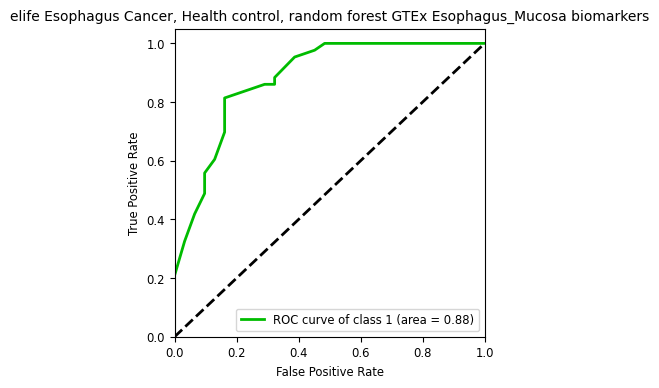

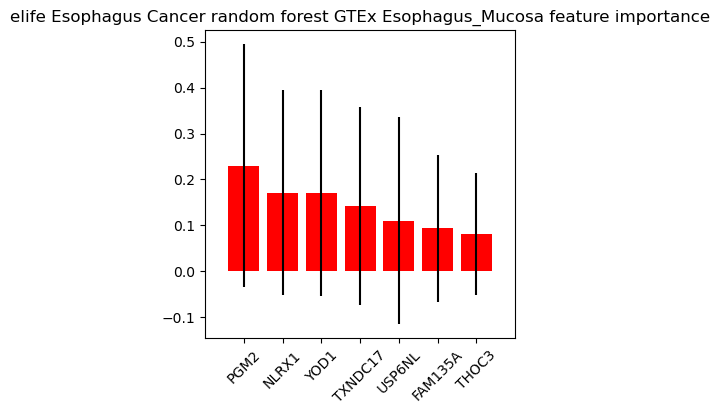

In [8]:
%%time
# mean AUC 0.0.6683
EsophagusDataDict = runAll( 
                        features=["Esophagus_Mucosa"],
                        selectElifeCategories=["Healthy donor", "Esophagus Cancer"],
                        setName='Esophagus_Mucosa',
                        cancerType="Esophagus"
                    )

# <span style="background-color:yellow">Lung Cancer</span>

2024-04-24 12:47:55,431 WARNING intraExtraRNA.elifeUtilities loadElifeTrainingData() line:178] [len(elifeLungGenes) : 10]
2024-04-24 12:47:55,433 WARNING intraExtraRNA.elifeUtilities loadElifeTrainingData() line:179] [missingElifeGenes
 : []]


HUGO_Genes
['FPR3', 'CSF3', 'SLAMF8', 'ENTPD2', 'MAGEE1', 'PCAT19', 'GRIP2', 'PTGIR', 'RND1', 'CHRNB1']

XNP.shape : (78, 10) yNP.shape : (78,)


,sample_id
diagnosis,
Healthy donor,43
Lung Cancer,35


labelEncoder
{'Healthy donor': 0, 'Lung Cancer': 1}

hyperParameterSearchResultsPath:
 /private/groups/kimlab/aedavids/elife/hyperparmeterTunning/randomForestHyperparmeterLungSearch.sh.out/randomForestHyperparmeterSearch.csv

 best hyperparameter search results


,accuracy_mean,accuracy_std,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,auc_mean,auc_std,max_features,max_samples,n_estimators,max_depth
0,0.7575,0.059184,0.714286,0.156492,0.788889,0.05152,0.751587,0.066371,3,1.0,500,NaN


{'max_features': 3, 'max_samples': 1.0, 'n_estimators': 500, 'max_depth': None}

RandomForestClassifier(max_features=3, max_samples=1.0, n_estimators=500,
                       random_state=42)

yNP.shape : (78,)
yProbability.shape : (78, 2)

saved roc plot to /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/img/elife-Lung-Cancer-Health-control-random-forest-GTEx-Lung-biomarkers.png

saved importance plot to /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/img/elife-Lung-Cancer-random-forest-GTEx-Lung-feature-importance.png
saved feature names: /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/model/elife-Lung-Cancer-Health-control-random-forest-GTEx-Lung-biomarkers_features.txt

 featureImportance:
[('ENTPD2', 0.18359252457051517), ('MAGEE1', 0.1808518097205886), ('PTGIR', 0.13198757088461943), ('SLAMF8', 0.10667691261087706), ('RND1', 0.10288278108072785), ('FPR3', 0.09784696735096902), ('CHRNB1', 0.07054906683992301), ('PCAT19', 0.05867154686716414), ('CSF3', 0.040563338080032), ('GRIP2', 0.02637748199458382)]

featureImportance saved to :
 /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestRes

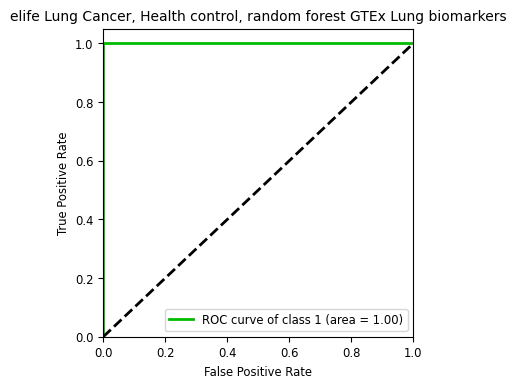

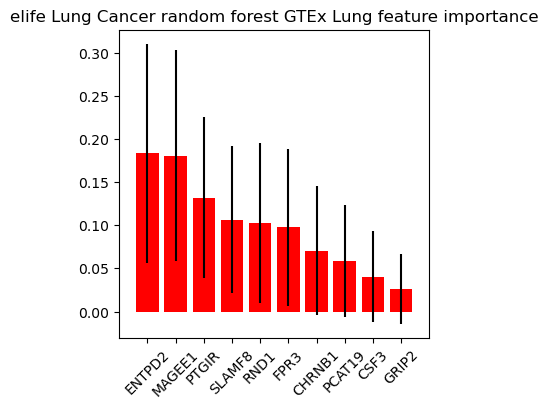

In [9]:
%%time
# aedavids@mustard $ head -n 2 `cat lung.csvs.txt ` | cut -d , -f 7
# ==> randomForestHyperparmeterAllSearch.sh.out/randomForestHyperparmeterSearch.csv <==
# auc_mean
# 0.7755952380952381

# ==> randomForestHyperparmeterLUADSearch.sh.out/randomForestHyperparmeterSearch.csv <==
# auc_mean
# 0.5968253968253968

# ==> randomForestHyperparmeterLung.sh.out/randomForestHyperparmeterSearch.csv <==
# auc_mean
# 0.7515873015873017

# ==> randomForestHyperparmeterLUSCSearch.sh.out/randomForestHyperparmeterSearch.csv <==
# auc_mean
# 0.5367063492063491

# Lung is probably better it uses fewer features
LungDataDict = runAll( 
                    features=["Lung"],
                    selectElifeCategories=["Healthy donor", "Lung Cancer"],
                    setName='Lung',
                    cancerType="Lung"
                )

# <span style="background-color:yellow">Liver Cancer</span>

2024-04-24 12:48:20,527 WARNING intraExtraRNA.elifeUtilities loadElifeTrainingData() line:178] [len(elifeLungGenes) : 10]
2024-04-24 12:48:20,529 WARNING intraExtraRNA.elifeUtilities loadElifeTrainingData() line:179] [missingElifeGenes
 : []]


HUGO_Genes
['SLC30A1', 'DNAJB9', 'MMUT', 'UBE2Q2', 'ERLIN1', 'ISOC2', 'OSBPL5', 'NIT2', 'EBNA1BP2', 'CCNG2']

XNP.shape : (69, 10) yNP.shape : (69,)


,sample_id
diagnosis,
Healthy donor,43
Liver Cancer,26


labelEncoder
{'Healthy donor': 0, 'Liver Cancer': 1}

hyperParameterSearchResultsPath:
 /private/groups/kimlab/aedavids/elife/hyperparmeterTunning/randomForestHyperparmeterLiverSearch.sh.out/randomForestHyperparmeterSearch.csv

 best hyperparameter search results


,accuracy_mean,accuracy_std,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,auc_mean,auc_std,max_features,max_samples,n_estimators,max_depth
0,0.825275,0.059928,0.613333,0.129271,0.952778,0.058002,0.783056,0.067084,2,NaN,100,4.0


2024-04-24 12:48:20,570 WARNING elifeBinaryRandomForestResults driver() line:81] [AEDWIP max_samples was None]


{'max_features': 2, 'max_samples': None, 'n_estimators': 100, 'max_depth': 4}

RandomForestClassifier(max_depth=4, max_features=2, random_state=42)

yNP.shape : (69,)
yProbability.shape : (69, 2)

saved roc plot to /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/img/elife-Liver-Cancer-Health-control-random-forest-GTEx-Liver-biomarkers.png

saved importance plot to /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/img/elife-Liver-Cancer-random-forest-GTEx-Liver-feature-importance.png
saved feature names: /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/model/elife-Liver-Cancer-Health-control-random-forest-GTEx-Liver-biomarkers_features.txt

 featureImportance:
[('ISOC2', 0.19795018492274927), ('NIT2', 0.18218180780502738), ('OSBPL5', 0.12054574482374121), ('SLC30A1', 0.11245285886910839), ('CCNG2', 0.0939367253205911), ('UBE2Q2', 0.07066820719190031), ('DNAJB9', 0.06280557638909232), ('MMUT', 0.061770729553299146), ('EBNA1BP2', 0.05691806107077383), ('ERLIN1', 0.04077010405371714)]

featureImportance saved to :
 /private/groups/kimlab/aedavids/elife/elifeBinaryR

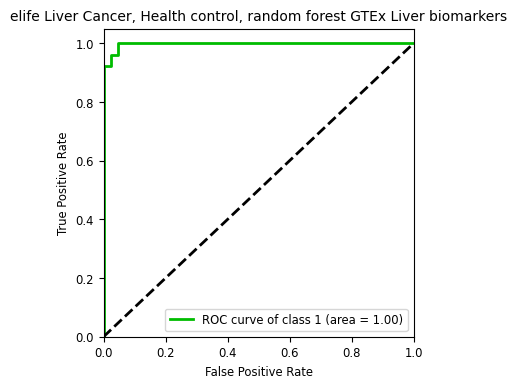

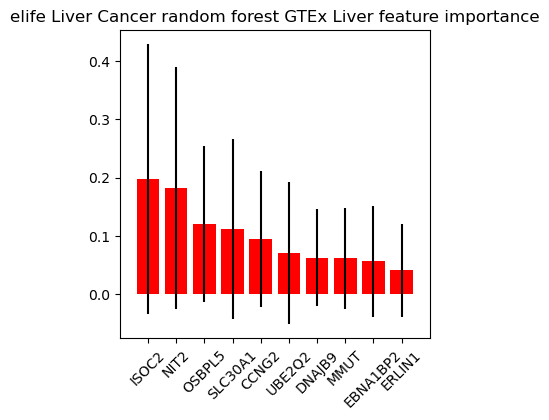

In [10]:
%%time
# mean AUC = 0.7831
liverDataDict = runAll( 
                    features=["Liver"],
                    selectElifeCategories=["Healthy donor", "Liver Cancer"],
                    setName='Liver',
                    cancerType="Liver"
                      )

# <span style="background-color:yellow">Stomach Cancer</span>

2024-04-24 12:48:44,300 WARNING intraExtraRNA.elifeUtilities loadElifeTrainingData() line:178] [len(elifeLungGenes) : 10]
2024-04-24 12:48:44,301 WARNING intraExtraRNA.elifeUtilities loadElifeTrainingData() line:179] [missingElifeGenes
 : ['ENSG00000171840.12']]


HUGO_Genes
['NINJ2', 'TLR6', 'TM6SF1', 'GKN2', 'HDC', 'AC012368.1', 'FLVCR2', 'ATP4B', 'CBLIF', 'GPR176']

XNP.shape : (79, 9) yNP.shape : (79,)


,sample_id
diagnosis,
Healthy donor,43
Stomach Cancer,36


labelEncoder
{'Healthy donor': 0, 'Stomach Cancer': 1}

hyperParameterSearchResultsPath:
 /private/groups/kimlab/aedavids/elife/hyperparmeterTunning/randomForestHyperparmeterStomachSearch.sh.out/randomForestHyperparmeterSearch.csv

 best hyperparameter search results


,accuracy_mean,accuracy_std,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,auc_mean,auc_std,max_features,max_samples,n_estimators,max_depth
0,0.833333,0.083333,0.835714,0.1,0.833333,0.185924,0.834524,0.078624,7,0.4,50,5.0


{'max_features': 7, 'max_samples': 0.4, 'n_estimators': 50, 'max_depth': 5}

RandomForestClassifier(max_depth=5, max_features=7, max_samples=0.4,
                       n_estimators=50, random_state=42)

yNP.shape : (79,)
yProbability.shape : (79, 2)

saved roc plot to /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/img/elife-Stomach-Cancer-Health-control-random-forest-GTEx-Stomach-biomarkers.png

saved importance plot to /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/img/elife-Stomach-Cancer-random-forest-GTEx-Stomach-feature-importance.png
saved feature names: /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/model/elife-Stomach-Cancer-Health-control-random-forest-GTEx-Stomach-biomarkers_features.txt

 featureImportance:
[('FLVCR2', 0.4396858969755869), ('GKN2', 0.23444261810303857), ('AC012368.1', 0.14781169626806676), ('CBLIF', 0.09836312522407052), ('ATP4B', 0.051779475753302044), ('HDC', 0.021194213993337), ('NINJ2', 0.006722973682598242), ('TLR6', 0.0), ('TM6SF1', 0.0)]

featureImportance saved to :
 /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/model/elife-Stomach-Cancer-Health-

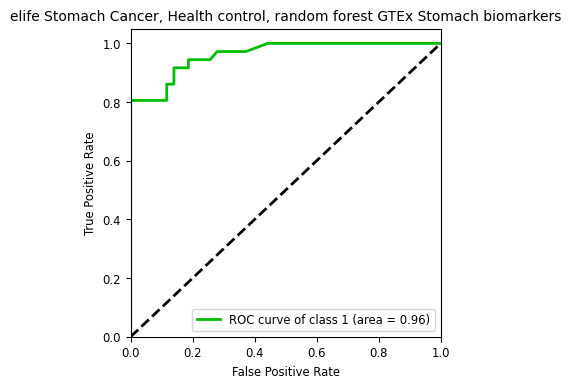

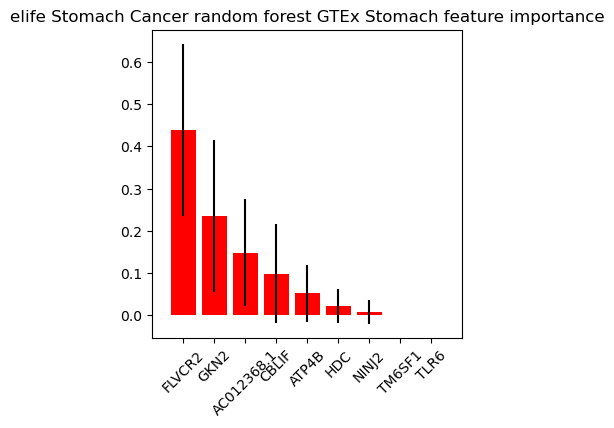

In [11]:
%%time
# mean AUC = 0.8345
stomachDataDict = runAll( 
                        features=["Stomach"],
                        selectElifeCategories=["Healthy donor", "Stomach Cancer"],    
                        setName='Stomach',
                        cancerType="Stomach",
                    )

# <span style="background-color:yellow">Colorectal Cancer</span>

2024-04-24 12:48:46,225 WARNING elifeBinaryRandomForestResults <module>() line:1] [randomForestHyperparmeterColon_SigmoidSearch.sh.log failed!!]
2024-04-24 12:49:08,912 WARNING intraExtraRNA.elifeUtilities loadElifeTrainingData() line:178] [len(elifeLungGenes) : 10]
2024-04-24 12:49:08,913 WARNING intraExtraRNA.elifeUtilities loadElifeTrainingData() line:179] [missingElifeGenes
 : []]


HUGO_Genes
['SLC35G2', 'DUBR', 'NOTUM', 'AC022400.7', 'ZNF304', 'SLC9A9', 'ZNF528', 'UBE2E2', 'DZIP1', 'IFIT1']

XNP.shape : (96, 10) yNP.shape : (96,)


,sample_id
diagnosis,
Healthy donor,43
Colorectal Cancer,53


labelEncoder
{'Colorectal Cancer': 0, 'Healthy donor': 1}

hyperParameterSearchResultsPath:
 /private/groups/kimlab/aedavids/elife/hyperparmeterTunning/randomForestHyperparmeterCOAD_Search.sh.out/randomForestHyperparmeterSearch.csv

 best hyperparameter search results


,accuracy_mean,accuracy_std,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,auc_mean,auc_std,max_features,max_samples,n_estimators,max_depth
0,0.791053,0.067885,0.7,0.190354,0.869091,0.095103,0.784545,0.070829,3,0.4,50,3.0


{'max_features': 3, 'max_samples': 0.4, 'n_estimators': 50, 'max_depth': 3}

RandomForestClassifier(max_depth=3, max_features=3, max_samples=0.4,
                       n_estimators=50, random_state=42)

yNP.shape : (96,)
yProbability.shape : (96, 2)

saved roc plot to /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/img/elife-Colorectal-Cancer-Health-control-random-forest-GTEx-COAD_-biomarkers.png

saved importance plot to /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/img/elife-Colorectal-Cancer-random-forest-GTEx-COAD_-feature-importance.png
saved feature names: /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/model/elife-Colorectal-Cancer-Health-control-random-forest-GTEx-COAD_-biomarkers_features.txt

 featureImportance:
[('IFIT1', 0.18089800552069366), ('DUBR', 0.17198307086929684), ('AC022400.7', 0.16597952254127382), ('DZIP1', 0.14649728481285387), ('UBE2E2', 0.1212136770377362), ('ZNF528', 0.05492587457143307), ('SLC9A9', 0.0523706159319389), ('ZNF304', 0.05222891884890391), ('NOTUM', 0.03575461434595978), ('SLC35G2', 0.01814841551990995)]

featureImportance saved to :
 /private/groups/kimlab/aedavids/el

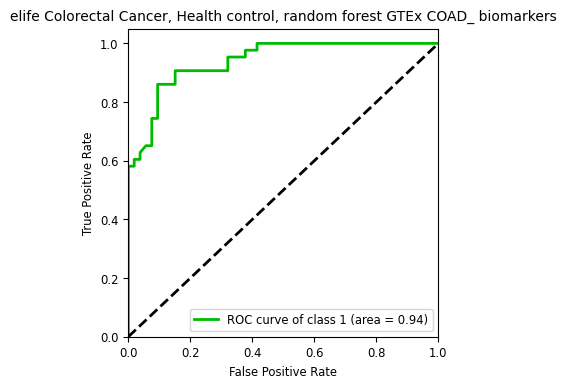

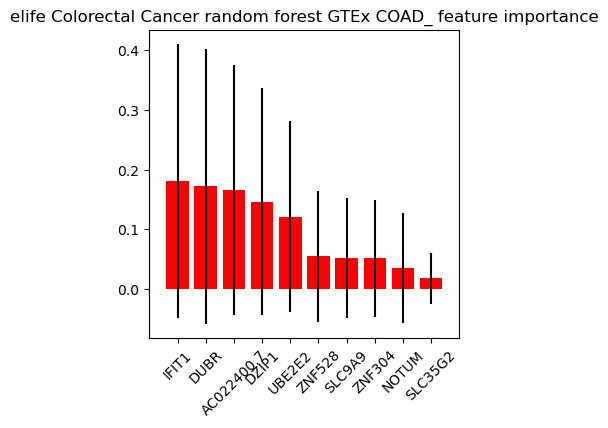

In [12]:
%%time
logger.warning('randomForestHyperparmeterColon_SigmoidSearch.sh.log failed!!')

# mean AUC = 0.7845
colorectalDataDict = runAll( 
                            features=["COAD"],
                            selectElifeCategories=["Healthy donor", "Colorectal Cancer"],    
                            setName='COAD_',
                            cancerType="Colorectal",
                        ) 

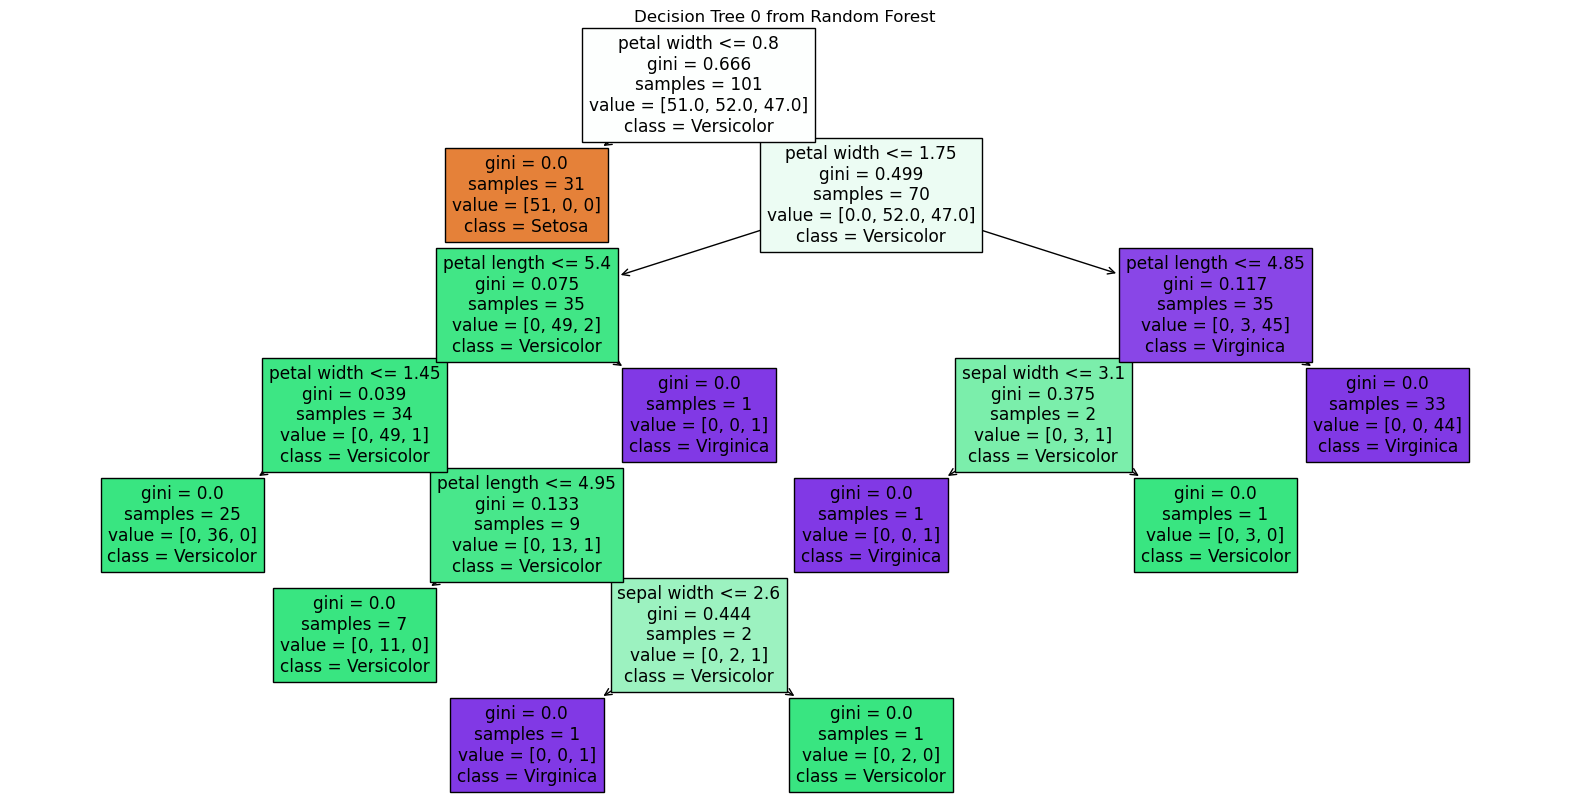

In [13]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

# Load the Iris dataset
X, y = load_iris(return_X_y=True)
# print(f'type(X): {type(X)} X :\n{X}')
# print(f'type(y): {type(y)} y : \n{y}')

# Train a RandomForestClassifier
model = RandomForestClassifier(random_state=42, n_estimators=10)  # using 10 trees for simplicity
model.fit(X, y)

# Select one tree from the forest
tree_index = 0  # selecting the first tree
single_tree = model.estimators_[tree_index]

# Plot the selected tree
plt.figure(figsize=(20,10))
plot_tree(single_tree, filled=True, feature_names=['sepal length', 'sepal width', 'petal length', 'petal width'], class_names=['Setosa', 'Versicolor', 'Virginica'])
plt.title(f"Decision Tree {tree_index} from Random Forest")
plt.show()

In [14]:
# try treeviz

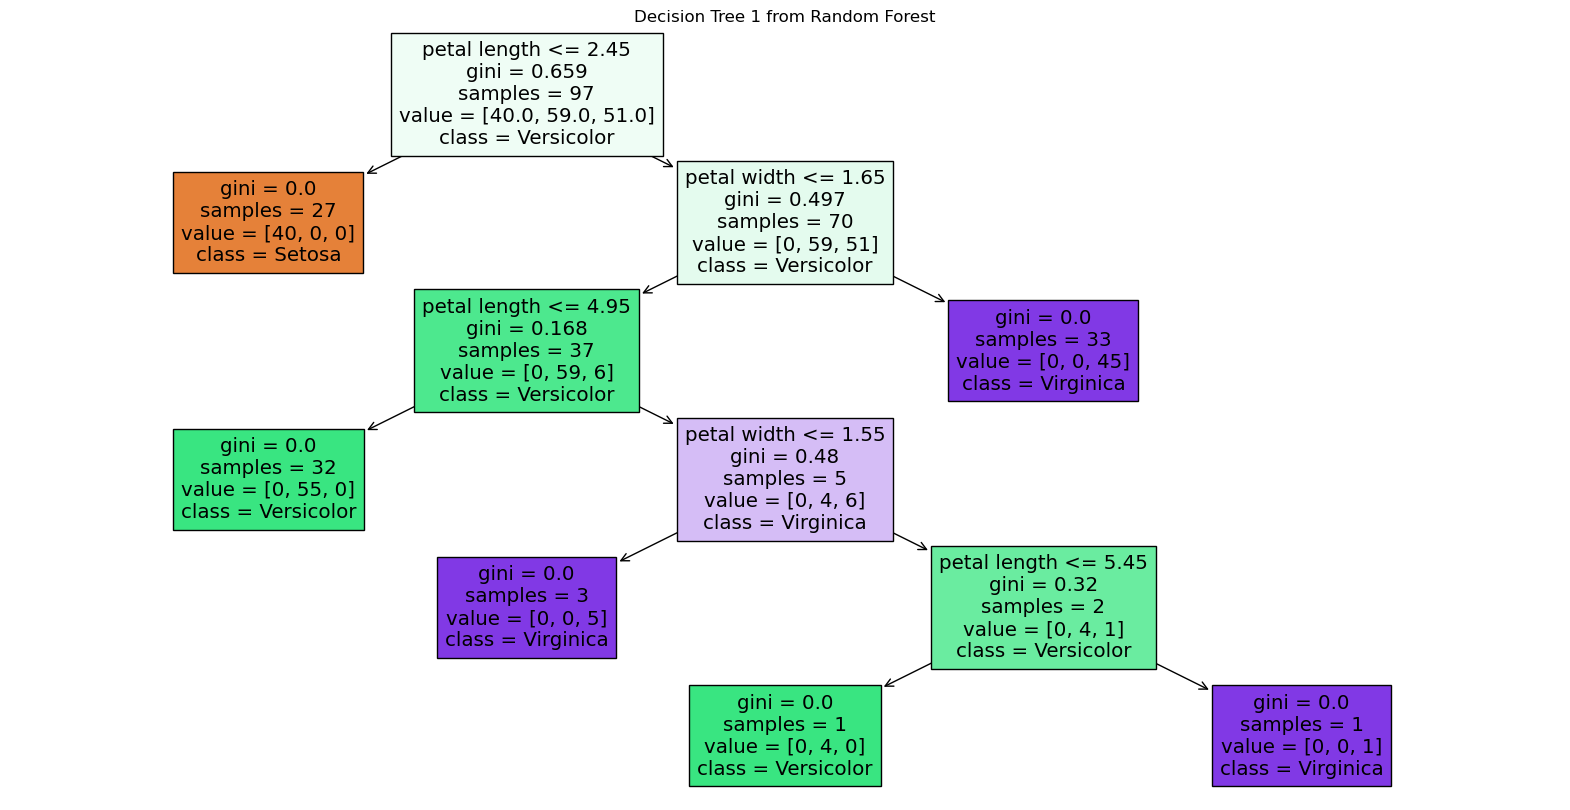

In [15]:
# Select one tree from the forest
tree_index = 1  # selecting the 2nd tree
single_tree = model.estimators_[tree_index]

# Plot the selected tree
plt.figure(figsize=(20,10))
plot_tree(single_tree, filled=True, feature_names=['sepal length', 'sepal width', 'petal length', 'petal width'], class_names=['Setosa', 'Versicolor', 'Virginica'])
plt.title(f"Decision Tree {tree_index} from Random Forest")
plt.show()

In [16]:
def esophTree():
    print(f'key: \n{EsophagusDataDict.keys()}')
    print(f'HUGO_Genes:\n{EsophagusDataDict["HUGO_Genes"]}')

esophTree()

key: 
dict_keys(['HUGO_Genes', 'elifeLungGenes', 'countDF', 'metaDF', 'XNP', 'yNP', 'labelEncoder', 'bestHyperparameterSearchResults', 'parameters', 'model', 'featureImportance'])
HUGO_Genes:
['FAM135A', 'YOD1', 'THOC3', 'USP6NL', 'NLRX1', 'TXNDC17', 'PGM2', 'DHRS1', 'TTC7B', 'PLD2']
